In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import nltk
import re
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import string

In [2]:
df = pd.read_csv("train.csv")
df.head()

,tweets,labels
0,sending solidarity whoever doctor manage incre...,Stressed
1,need see hair amp beard gat book appointment b...,Anxious
2,next time meet someone new dont ask ask love,Normal
3,surprise someone love give la senza gift box r...,Lonely
4,raise hand junhoes ocean lotion life rent free...,Normal


In [3]:
def preprocess_text(df,column_name):
    
    df[column_name] = df[column_name].apply(lambda x: " ".join(x.lower() for x in x.split()))
    df[column_name] = df[column_name].str.replace('[^\w\s]','')
    #remove stop words
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    df[column_name] = df[column_name].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    #spell correct 
    #df[column_name].apply(lambda x: str(TextBlob(x).correct()))
    st = PorterStemmer()
    df[column_name][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
    #lemmatize
    df[column_name] = df[column_name].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return df
    

In [4]:
preproeessed_df_train = preprocess_text(df,"tweets")
preproeessed_df_train

/var/folders/5_/sp1gmv7n21g5ytt_51_ys5d80000gn/T/ipykernel_67625/984969602.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace('[^\w\s]','')


,tweets,labels
0,sending solidarity whoever doctor manage incre...,Stressed
1,need see hair amp beard gat book appointment b...,Anxious
2,next time meet someone new dont ask ask love,Normal
3,surprise someone love give la senza gift box r...,Lonely
4,raise hand junhoes ocean lotion life rent free...,Normal
...,...,...
29987,originsmp originssmp,Normal
29988,name muhammad asif farooqi im pakistan amp sta...,Lonely
29989,mom mad wont go overnight skiing trip 5 people...,Stressed
29990,even tonight youre go bed date someone cannot ...,Normal


In [5]:
frequency_dist = nltk.FreqDist(df['tweets'])
ordereddist =sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)

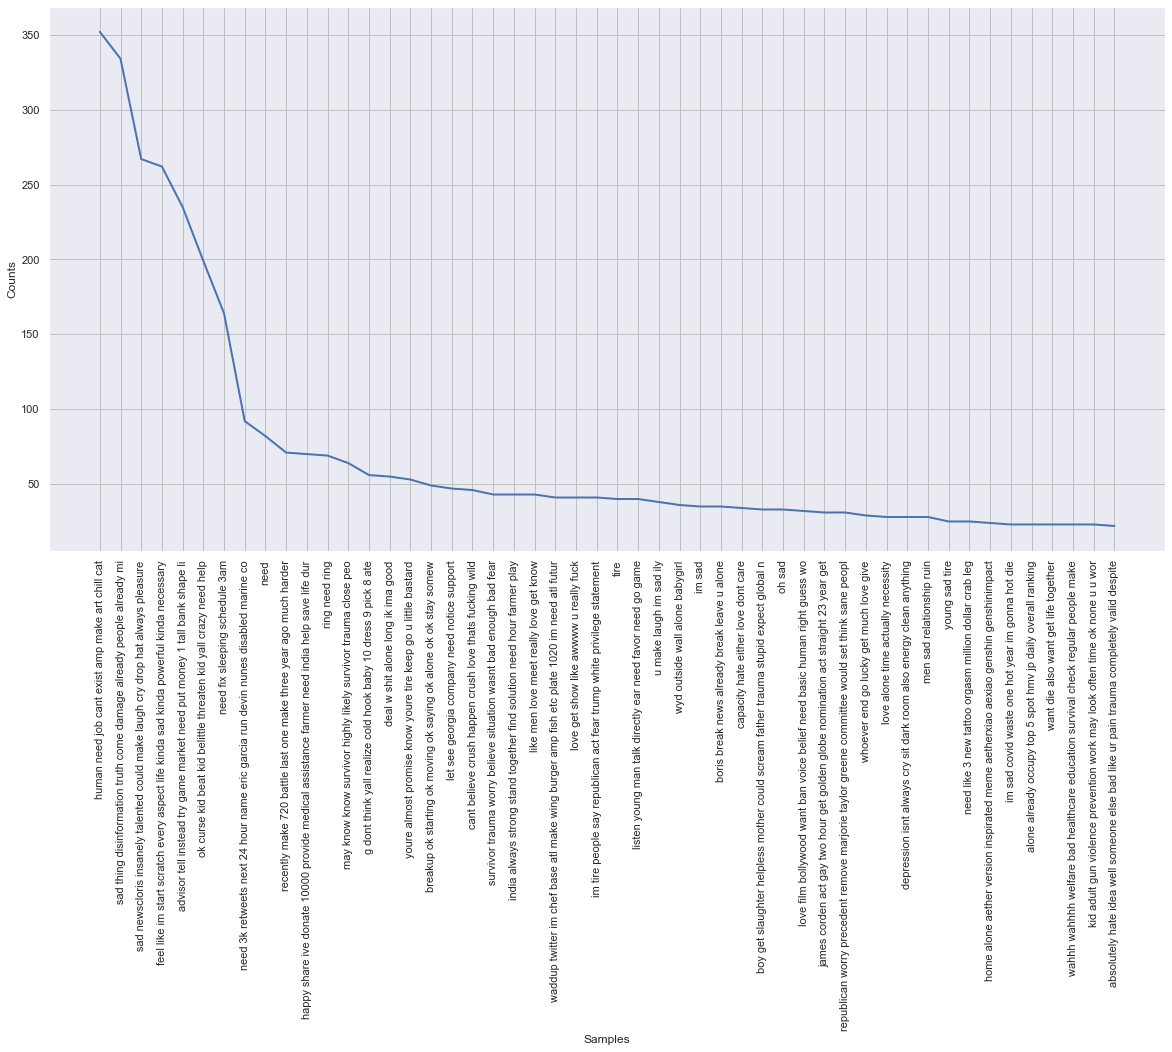

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [6]:
sns.set(rc={'figure.figsize':(20,10)})
large_words = dict([(k,v) for k,v in frequency_dist.items() if len(k)>3])
frequency_dist = nltk.FreqDist(large_words)
frequency_dist.plot(50,cumulative=False)  

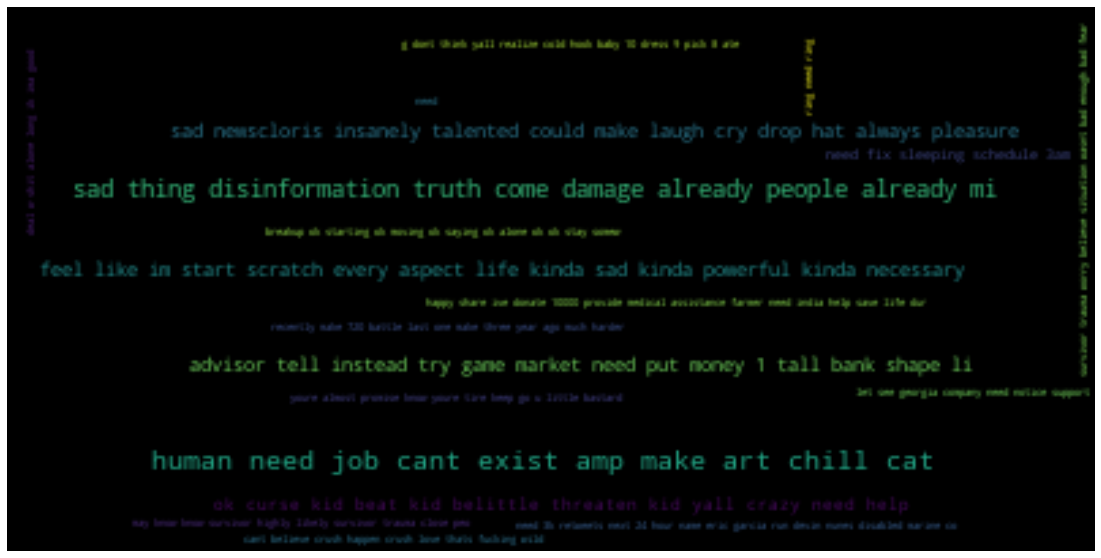

In [7]:
sns.set(rc={'figure.figsize':(20,10)})
from wordcloud import WordCloud
wcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off") 
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(preproeessed_df_train["tweets"],
                                                      preproeessed_df_train["labels"],
                                                     random_state=4546,
                                                     test_size=0.3)

In [10]:
X_train.head()

16555    would accurate say trudeau toss emergency pand...
3758                                    need get close god
13634    protocontroversy around lawfare piece speed co...
13775                                             im tired
19559    midnight snack part 1 comic crumb_boy poor fox...
Name: tweets, dtype: object

In [11]:
X_train.shape, X_valid.shape

((20994,), (8998,))

In [12]:
encoder = preprocessing.LabelEncoder()

In [13]:
tfidf = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf.fit(X_train)
encoded_X_train =  tfidf.transform(X_train)
encoded_X_valid =  tfidf.transform(X_valid)
encoded_X_train.data

array([0.22583806, 0.45037087, 0.20046882, ..., 0.65042601, 0.27653053,
       0.70744389])

In [14]:
#naive bayes
nb = naive_bayes.MultinomialNB(alpha=0.2)

In [15]:
nb.fit(encoded_X_train,y_train)
predict = nb.predict(encoded_X_valid)
metrics.accuracy_score(predict, y_valid)

0.5435652367192709

In [16]:
predict

array(['Normal', 'Normal', 'Anxious', ..., 'Normal', 'Stressed',
       'Anxious'], dtype='<U8')

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [18]:
gbfparams = {
             'learning_rate':[0.001,0.01,0.0001],
             'max_features': [2, 3,5,7],
             'min_samples_leaf': [3, 4, 5,7,9],
             'n_estimators':[100,200,300,500]             
            }
gb_gridcv = GridSearchCV(GradientBoostingClassifier(random_state=412), gbfparams, verbose=1, n_jobs=12,cv=10)

In [19]:
gb_gridcv.fit(encoded_X_train,y_train)
gbpredict = gb_gridcv.predict(encoded_X_valid)
metrics.accuracy_score(gbpredict, y_valid)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


0.5038897532785064

In [20]:
gbpredict

array(['Normal', 'Normal', 'Normal', ..., 'Normal', 'Anxious', 'Anxious'],
      dtype=object)

In [21]:
rfparams = {'n_estimators':[100,200,300,500],
            'max_features':['auto','log2','sqrt'],
            'criterion':['gini','entropy'],
            'min_samples_split': [3,5,8,9,10,30,50]}
rf_gridcv = GridSearchCV(RandomForestClassifier(random_state=42), rfparams, verbose=1, n_jobs=12, cv=10)
rf_gridcv.fit(encoded_X_train,y_train)
rf_pred = rf_gridcv.predict(encoded_X_valid)
metrics.accuracy_score(rf_pred, y_valid)

Fitting 10 folds for each of 168 candidates, totalling 1680 fits


0.6560346743720827

In [22]:
rf_pred

array(['Stressed', 'Normal', 'Anxious', ..., 'Anxious', 'Stressed',
       'Anxious'], dtype=object)

In [23]:
test_df = pd.read_csv("test.csv")

In [25]:
preprocess_test=preprocess_text(test_df,"tweets")

/var/folders/5_/sp1gmv7n21g5ytt_51_ys5d80000gn/T/ipykernel_67625/984969602.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace('[^\w\s]','')


In [26]:
preprocess_test

,id,tweets
0,0,wish luck need start cooking
1,1,ino didnt need weapon need backup cause damn s...
2,2,good thing know walk away
3,3,say fat people get tire fast
4,4,need buy fucken car already
...,...,...
7494,7494,love mercedes justine kestner varnadohelp thanks
7495,7495,junkie xl score everyone damn beautifuk
7496,7496,92e3201a battle id need backup lvl 200 ultimat...
7497,7497,tangina naiiyak ako sa mga nangyayari please n...


In [28]:
rf_prediction = rf_gridcv.predict(tfidf.transform(preprocess_test["tweets"]))
rf_prediction

array(['Anxious', 'Lonely', 'Normal', ..., 'Lonely', 'Lonely', 'Stressed'],
      dtype=object)

In [33]:
res_rf = pd.concat([preprocess_test["id"],pd.DataFrame(rf_prediction,columns=['labels'])],axis=1)
res_rf

,id,labels
0,0,Anxious
1,1,Lonely
2,2,Normal
3,3,Stressed
4,4,Lonely
...,...,...
7494,7494,Anxious
7495,7495,Normal
7496,7496,Lonely
7497,7497,Lonely


In [35]:
res_rf.to_csv("rf_submission1.csv",index=False)

In [ ]:
#other Advanced encoding technique such as BERT can also be used 